<a href="https://colab.research.google.com/github/nataliarestrada/IPDI-Estrada/blob/main/PDI_TP03_Estrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Practico N°3 - Operaciones de luminancia
Asignatura: **Introducción al Procesamiento Digital de Imágenes (PDI)**

Alumno: **Natalia R. Estrada** - email: nataliarominaestrada@gmail.com

La actividad propuesta:
* 1- Abrir una imagen, y luego ver la imagen procesada.
* 2- Se debe poder elegir filtro raíz, cuadrado, o lineal a trozos.


####Desarrollo
Importamos las librerias necesarias

In [1]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from google.colab import files

Funciones necesarias para realizar las operaciones

In [6]:
#Función para convertir una imagen del espacio RGB al YIQ
def rgb_to_yiq(RGB):
    '''
    input: matriz de la imagen en formato RGB normalizada
    output: matriz de la imagen en formato YIQ
    '''
    rgb2yiq_matrix = np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
    #print("Matriz de conversion RGB a YIQ:")
    #print(rgb2yiq_matrix)

    #Se normalizan los valores de RGB entre 0.0 y 1.0
    RGB = RGB/255 

    Y = rgb2yiq_matrix[0][0] * RGB[:,:,0] + rgb2yiq_matrix[0][1] * RGB[:,:,1] + rgb2yiq_matrix[0][2] * RGB[:,:,2]
    I = rgb2yiq_matrix[1][0] * RGB[:,:,0] + rgb2yiq_matrix[1][1] * RGB[:,:,1] + rgb2yiq_matrix[1][2] * RGB[:,:,2]
    Q = rgb2yiq_matrix[2][0] * RGB[:,:,0] + rgb2yiq_matrix[2][1] * RGB[:,:,1] + rgb2yiq_matrix[2][2] * RGB[:,:,2]

    Y = np.clip(Y, 0, 1)
    I = np.clip(I, -0.5957, 0.5957)
    Q = np.clip(Q, -0.5226, 0.5226)
    
    YIQ = np.dstack((Y,I,Q))
    
    return YIQ

#Función para convertir una imagen del espacio YIQ al RGB 
def yiq_to_rgb(YIQ):
    '''
    input: matriz de la imagen en formato YIQ 
    output: matriz de la imagen en formato RGB (en bytes)
    '''
    yiq2rgb_matrix = np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
    #print("Matriz de conversion YIQ a RGB:")
    #print(yiq2rgb_matrix)

    R = yiq2rgb_matrix[0][0] * YIQ[:,:,0] + yiq2rgb_matrix[0][1] * YIQ[:,:,1] + yiq2rgb_matrix[0][2] * YIQ[:,:,2]
    G = yiq2rgb_matrix[1][0] * YIQ[:,:,0] + yiq2rgb_matrix[1][1] * YIQ[:,:,1] + yiq2rgb_matrix[1][2] * YIQ[:,:,2]
    B = yiq2rgb_matrix[2][0] * YIQ[:,:,0] + yiq2rgb_matrix[2][1] * YIQ[:,:,1] + yiq2rgb_matrix[2][2] * YIQ[:,:,2]

    #Se controla que no haya pixeles con valores menores a 0 y mayores a 1 (Dadas las multiplicaciones y sumas realizadas,
    #puede ocurrir que un valor exceda un poco el límite de 255 o sea ligeramente menor a 0 ocasionando errores en la visualización)
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    #Se convierten los valores a byte (valores enteros de 0 a 255)
    R = (R*255).astype(int)
    G = (G*255).astype(int)
    B = (B*255).astype(int)    
    
    RGB = np.dstack((R,G,B))
    
    return RGB

#---------------------------------------------------------------------------------------------------
#Función para aplicar filtro lineal a trozos
def linealATrozos(image, y_in_min, y_in_max):
  y_out_min = 0
  y_out_max = 1

  #Ecuación de la recta: y-y1 = m(x-x1) --> y = mx + b
  m = (y_out_max - y_out_min)/(y_in_max - y_in_min) #pendiente entre (y_in_min e y_in_max)
  b = y_out_min - m * y_in_min #ordenada al origen
  
  YIQ = rgb_to_yiq(image)
  Y = YIQ[:,:,0]
  I = YIQ[:,:,1]
  Q = YIQ[:,:,2]

  Y[Y < y_in_min] = 0
  Y[Y > y_in_max] = 1
  Y = np.where((Y >= y_in_min) & (Y <= y_in_max), m * Y + b, Y)

  YIQ_new = np.dstack((Y, I, Q))
  return YIQ_new

#Función para aplicar filtro raiz cuadrada
def raizCuadrada(image):
  YIQ = rgb_to_yiq(image)
  Y = YIQ[:,:,0]
  I = YIQ[:,:,1]
  Q = YIQ[:,:,2]
  Y_new = Y ** 0.5
  YIQ_new = np.dstack((Y_new,I,Q))
  return YIQ_new

#Función para aplicar filtro potencia cuadratica
def potenciaCuadratica(image):
  YIQ = rgb_to_yiq(image)
  Y = YIQ[:,:,0]
  I = YIQ[:,:,1]
  Q = YIQ[:,:,2]
  Y_new = Y * Y
  YIQ_new = np.dstack((Y_new,I,Q))
  return YIQ_new

#Función para generar los valores del histograma emplenado numpy---------------------------------------------------------------
def generate_histo(Y, min, max, steps):
  
  bins = np.round(np.linspace(min, max, steps+1),6) #Genera las divisiones en base al número de contadores(steps)
  #Aclaración: se redondea a 6 decimales como máximo para evitar errores debido a la representación de los números con punto flotante
  counts, bins_edges = np.histogram(Y, bins)

  #Cálculo de la frecuencia relativa para generar el histograma de frecuencia
  total_counts = sum(counts)
  counts_relative_freq = np.round(((counts*100)/total_counts),2)
  return counts_relative_freq, bins_edges

#Función para plotear una imagen y su histograma en la misma figura
def plot_image_histo(image, counts_relative_freq, bins, steps, figsize=(15,5), title='Imagen'):

  fig, axs = plt.subplots(1,2,figsize=figsize)
  
  plt.subplot(1,2,1)
  plt.imshow(image)
  plt.title(title)
  
  plt.subplot(1,2,2)
  plt.bar((bins[1:] + bins[:-1])/2, counts_relative_freq, width=bins[1] - bins[0], color='cornflowerblue', ec='black')
  plt.title("Histograma de Luminancias")
  plt.xlabel("Luminancias")
  plt.ylabel("Frecuencia %")
  plt.xticks(np.arange(0,1.01,(bins[1] - bins[0])))

  plt.tight_layout()
  plt.show()

##Bloque principal del programa.

1. Ingresar la imagen a la cual queremos aplicar las funciones


> `Cuentas con 2 opciones para cargar la imagen, utiliza la que te sea mas comoda` 😁



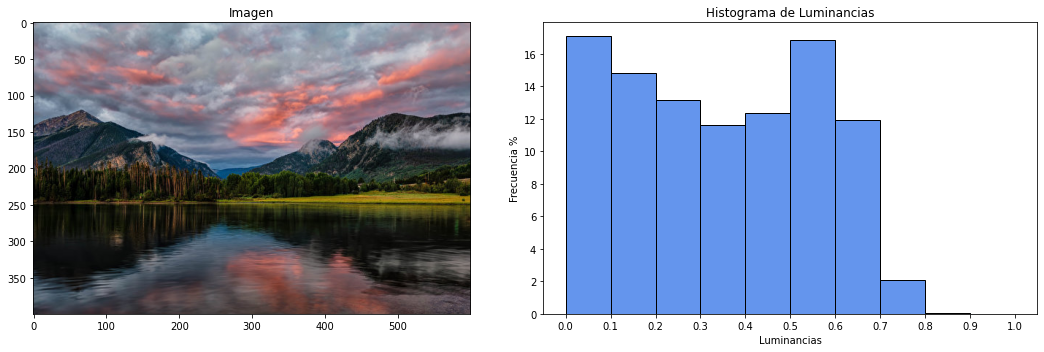

In [78]:
#@title Ingrese imagen mediante url: { run: "auto", vertical-output: true }
imagen = "https://s1.1zoom.me/prev/596/USA_Mountains_Lake_Forests_Sky_Lake_Dillon_Clouds_595131_600x400.jpg" #@param {type:"string"}

#Leo la imagen
img = io.imread(imagen)

cont = 10
img_yiq = rgb_to_yiq(img)
img_y = img_yiq[:,:,0] #Extracción del canal Y (luminancia) de la imagen

#obtengo las frecuencias de la limunancia
counts_relative_freq, bins = generate_histo(img_y,0, 1, cont)
#grafico la imagen juanto al histograma de las luminancias
plot_image_histo(img, counts_relative_freq, bins, cont)


Saving lena512.png to lena512.png


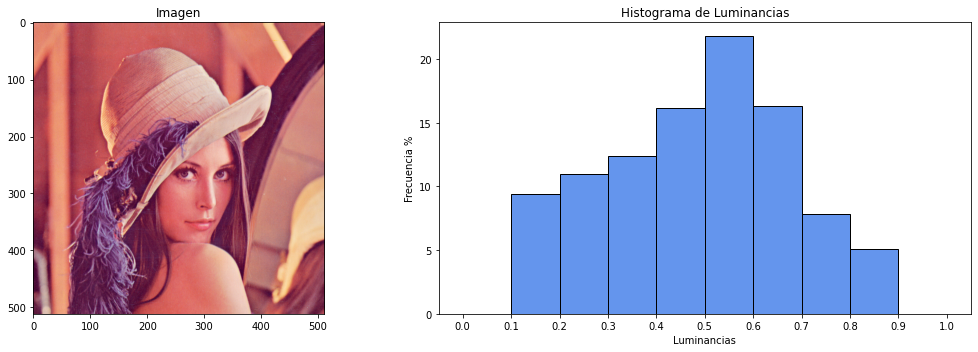

In [67]:
#@title Ingrese imagen desde su equipo: { run: "auto", vertical-output: true }
uploaded = files.upload()

for fn in uploaded.keys():
  name=fn

imagen = name
#Leo la imagen
img = io.imread(imagen)

cont = 10
img_yiq = rgb_to_yiq(img)
img_y = img_yiq[:,:,0] #Extracción del canal Y (luminancia) de la imagen

#obtengo las frecuencias de la limunancia
counts_relative_freq, bins = generate_histo(img_y,0, 1, cont)
#grafico la imagen juanto al histograma de las luminancias
plot_image_histo(img, counts_relative_freq, bins, cont)


2. Elija el filtro que deseamos aplicar a la imagen

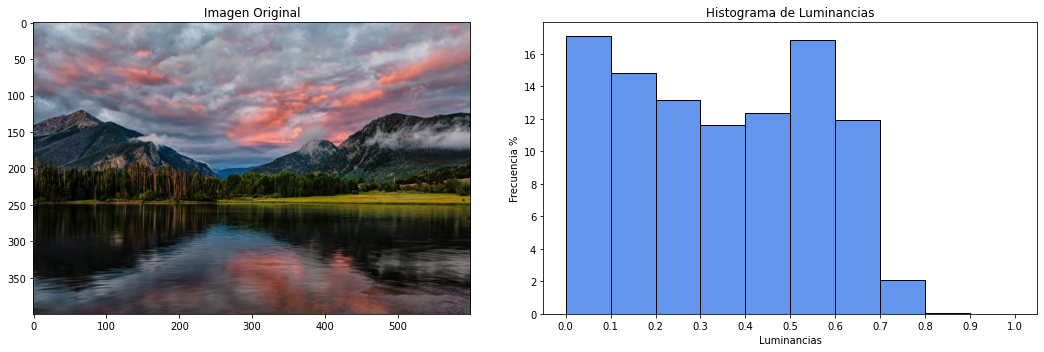

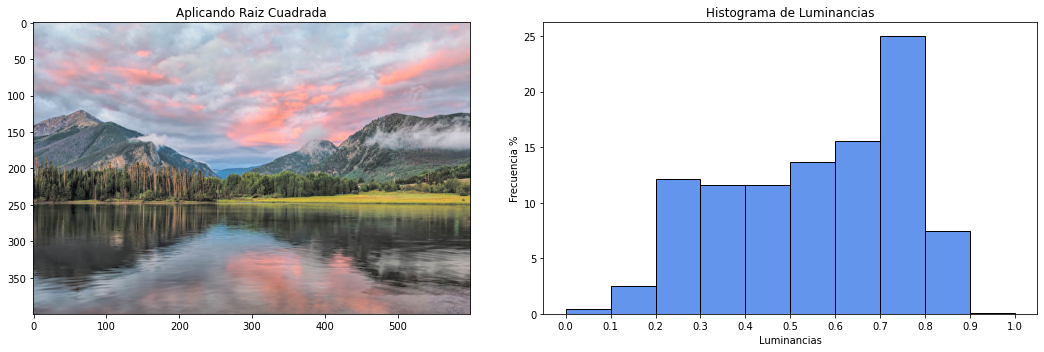

In [82]:
#@title Seleccione la función a aplicar: { run: "auto", vertical-output: true }

Funcion = 'Raiz_cuadrada' #@param ["Potencia_cuadratica", "Raiz_cuadrada", "Lineal_a_trozos"]

if Funcion == 'Potencia_cuadratica':
  yiq_mod = potenciaCuadratica(img)
  img_mod = yiq_to_rgb(yiq_mod) #convierto a RGB para mostrar la imagen
  titulo='Aplicando Potencia Cuadratica'
elif Funcion == 'Raiz_cuadrada':
  yiq_mod = raizCuadrada(img)
  img_mod = yiq_to_rgb(yiq_mod) #convierto a RGB para mostrar la imagen
  titulo='Aplicando Raiz Cuadrada'
elif Funcion == 'Lineal_a_trozos':
  y_min=0.2
  y_max=0.8
  yiq_mod = linealATrozos(img,y_min,y_max)
  img_mod = yiq_to_rgb(yiq_mod) #convierto a RGB para mostrar la imagen
  titulo='Aplicando Lineal a trozos con Y_min=' + str(y_min) + ', Y_max=' + str(y_max)

counts_relative_freq_mod, bins_mod = generate_histo(yiq_mod[:,:,0],0, 1, cont)

plot_image_histo(img, counts_relative_freq, bins, cont, title='Imagen Original')

plot_image_histo(img_mod, counts_relative_freq_mod, bins_mod, cont, title=titulo)

> Anteriormente para la funcion Lineal a trozos se utilizaron los valores Ymin=0.2 y Ymax=0.8

> Pero que pasa si modificamos esos valores? Averiguemoslo 👇🏼 

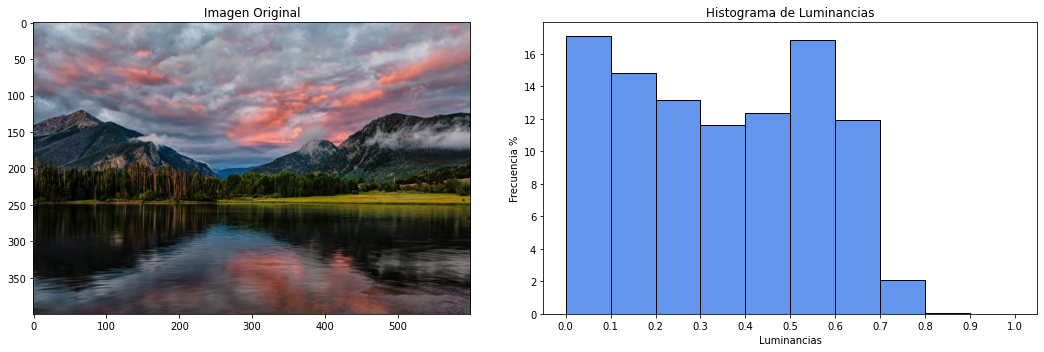

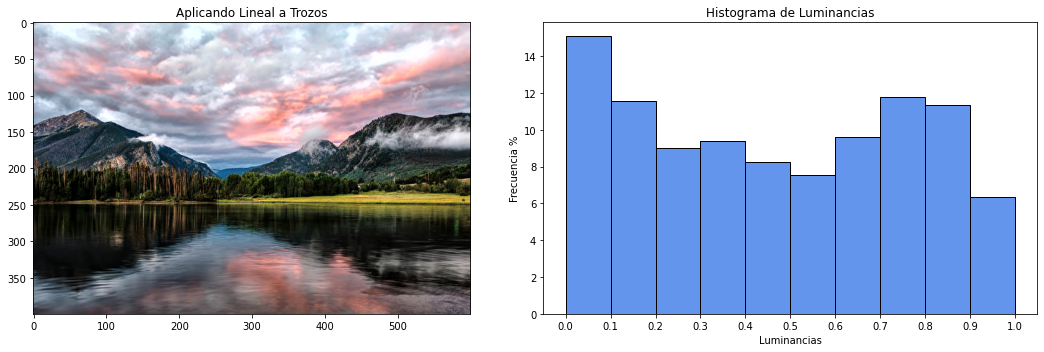

In [88]:
#@title Lineal a Trozos  { run: "auto", vertical-output: true }
Y_min = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
Y_max = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}

yiq_mod = linealATrozos(img,Y_min,Y_max)
img_mod = yiq_to_rgb(yiq_mod) #convierto a RGB para mostrar la imagen
counts_relative_freq_mod, bins_mod = generate_histo(yiq_mod[:,:,0],0, 1, cont)

plot_image_histo(img, counts_relative_freq, bins, cont, title='Imagen Original')
plot_image_histo(img_mod, counts_relative_freq_mod, bins_mod, cont, title='Aplicando Lineal a Trozos')

# Conclusion
Luego de haber analizado los 3 filtros (potencia cuadrática, raíz cuadrática y lineal a trozos) se puede concluir que, antes de aplicar cualquier filtro es necesario analizar su histograma de luminancia, ya que este influye en la decisión del filtro a emplear.

* Para imágenes con predominancia de luminancias bajas --> filtro de raíz cuadrática

* Para imágenes con predominancia de luminancias altas --> filtro de potencia cuadrática

* Para imágenes con predominancia de luminancias medias --> filtro lineal a trozos